In [1]:
import pandas as pd
import numpy as np
import json
import ast
from tqdm import tqdm
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem


In [6]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection    
    if union == 0:
        return 0.0
    else:
        jaccard_similarity = intersection / union
        return jaccard_similarity
    
def extract_answer(text):
    pattern = r'{[^{}]*}'
    match = re.search(pattern, text)
    if match:
        return match.group()
    else:
        return None
    
def extract_by_splitting(text):
    compound_list = text.split(':')[1].split("Diseases")[0].split("], ")[0]+"]"
    disease_list = text.split(':')[-1].split("}")[0]
    resp = {}
    resp["Compounds"] = ast.literal_eval(compound_list)
    resp["Diseases"] = ast.literal_eval(disease_list)
    return resp
    
    
def get_hyperparam_perf(files):
    llm_performance_list = []
    for file in tqdm(files):
        df = pd.read_csv(os.path.join(PARENT_PATH, file))
        df.dropna(subset=["llm_answer"], inplace=True)
        llm_performance_list_across_questions = []
        for index, row in df.iterrows():
            cmp_gt = ast.literal_eval(row["compound_groundTruth"])
            disease_gt = ast.literal_eval(row["disease_groundTruth"])
            try:
                llm_answer = json.loads(extract_answer(row["llm_answer"]))
            except:
                llm_answer = extract_by_splitting(row["llm_answer"])
            cmp_llm = llm_answer["Compounds"]
            disease_llm = llm_answer["Diseases"]
            cmp_similarity = jaccard_similarity(cmp_gt, cmp_llm)
            disease_similarity = jaccard_similarity(disease_gt, disease_llm)
            llm_performance = np.mean([cmp_similarity, disease_similarity])
            llm_performance_list_across_questions.append(llm_performance)
        llm_performance_list.append((np.mean(llm_performance_list_across_questions), np.std(llm_performance_list_across_questions), sem(llm_performance_list_across_questions), row["context_volume"]))
    hyperparam_perf = pd.DataFrame(llm_performance_list, columns=["performance_mean", "performance_std", "performance_sem", "context_volume"])        
    return hyperparam_perf


In [3]:
PARENT_PATH = "../../../data/analysis_results/"


FILES_1 = [
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_1.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_2.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_3.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_4.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_5.csv"
]

FILES_2 = [
    "gpt_4PubMedBert_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_1.csv",
    "gpt_4PubMedBert_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_2.csv",
    "gpt_4PubMedBert_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_3.csv",
    "gpt_4PubMedBert_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_4.csv",
    "gpt_4PubMedBert_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_5.csv"
]


In [8]:
mini_lm_perf = get_hyperparam_perf(FILES_1)
pubmedBert_perf = get_hyperparam_perf(FILES_2)


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 109.44it/s]


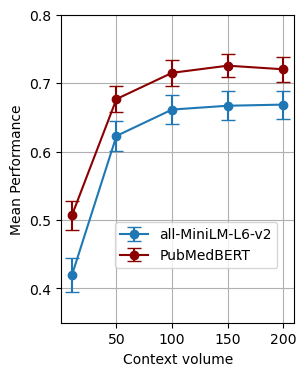

In [42]:


params = mini_lm_perf.context_volume.values
mini_lm_mean_performance = mini_lm_perf.performance_mean.values
mini_lm_std_deviation = mini_lm_perf.performance_std.values
mini_lm_sem_value = mini_lm_perf.performance_sem.values

pubmedBert_mean_performance = pubmedBert_perf.performance_mean.values
pubmedBert_std_deviation = pubmedBert_perf.performance_std.values
pubmedBert_sem_value = pubmedBert_perf.performance_sem.values

fig = plt.figure(figsize=(3, 4))
plt.errorbar(params, mini_lm_mean_performance, yerr=mini_lm_sem_value, fmt='o-', capsize=5, label='all-MiniLM-L6-v2')
plt.errorbar(params, pubmedBert_mean_performance, yerr=pubmedBert_sem_value, fmt='o-', capsize=5, label='PubMedBERT', color="darkred")
plt.xlabel('Context volume')
plt.ylabel('Mean Performance')
plt.grid(True)
plt.ylim(0.35,0.8)
plt.legend(bbox_to_anchor=(0.2, 0.35))
plt.show()


figure_folder_name = "hyperparam_tuning"
fig_filename = "../../../data/analysis_results/figures/{}/context_volume_one_hop_miniLM_vs_PubMedBert.svg".format(figure_folder_name)
fig.savefig(fig_filename, format='svg', bbox_inches='tight')

